# <span style="font-size:1.3em;">Petfinder Pawpularity Prediction Using Neural Networks
Authors: Aisha Baitemirova-Othman, Angela Kim, Steven Addison

---

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>  
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#Baseline Dummy Regressor">Baseline Dummy Regressor</a>
    
    - <a href="#First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>
    
    - <a href="#Iterative Artificial Neural Network Building">Iterative Artificial Neural Networks</a>
    
    - <a href="#Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Networks</a>
    
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

---

# <a id="#Overview">Overview</a>

> [Petfinder.my](https://www.petfinder.my/) is Malaysia’s leading animal welfare platform, featuring over 200,000 animals with more than 56,000 happily adopted. This project analyzes photos of adoptable pets from Malaysian animal shelters found on Petfinder and designs a Deep Learning model to predict the "Pawpularity" of pet photos.

# <a id="#Business Understanding">Business Understanding</a>

>They say a picture is worth a thousand words. A picture can also save a life. Hundreds of millions of stray cats and dogs suffer on the streets, live miserably in crowded shelters, or are euthanized around the world. Companion animals with attractive and high quality photos are more likely to be adopted and more likely to be adopted faster [source](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796). We want to answer the question: what makes a good picture? After analyzing raw images and metadata to predict the “Pawpularity” of pet photos, we train and test our model on PetFinder.my's thousands of pet profiles to come up with the best recommendations on photo composition. We hope our model will help stray cats and dogs find their "furever" home faster.

# <a id="Data Understanding">Data Understanding</a>

>The data comes from thousands of pet profiles on [Petfinder.my](https://www.petfinder.my/). The `Pawpularity` score is derived from each pet profile's page view statistics at the listing pages, using an algorithm that normalizes the traffic data across different pages, platforms (web & mobile) and various metrics. Duplicate clicks, crawler bot accesses and sponsored profiles are excluded from the analysis. All the feature metadata is explained [here](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md).
---

# <a id="Imports">Imports</a>

> First, we start with importing the relevant libraries to load and clean our dataset.

In [1]:
#pip install opencv-python
#pip install scikit-image

In [2]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras

from skimage.transform import resize
from skimage import color, io

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

In [3]:
# Open .csv file as pandas dataframe
df = pd.read_csv("data/train.csv")

In [4]:
# Initial look at dataframe
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
# Count of non-null values, datatypes, and total entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
# Check descriptive statistics
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
# Check value counts
for c in df.columns:
    print ("---- %s ----" % c)
    print (df[c].value_counts())
    print("\n")

---- Id ----
a9894bf4223185f48188a545044aeefa    1
c97498a8f67676fed254ae35e735a312    1
d20cf059a9e892dcb8bb991bf5acf010    1
b6004a1d03498ef6ef362685e38535e2    1
2aee7c914c13f432e20c842ce71dbfd9    1
                                   ..
a450cd16e284e1fc9affba674a63c154    1
4a4b92b7387e75223b2fd1e502e71ce3    1
5dadbfa60882b172cc2f0710aaefb9f1    1
87abac899ef38e21df16edab73e05307    1
efc51b5700c80e739d81f83bd21ef735    1
Name: Id, Length: 9912, dtype: int64


---- Subject Focus ----
0    9638
1     274
Name: Subject Focus, dtype: int64


---- Eyes ----
1    7658
0    2254
Name: Eyes, dtype: int64


---- Face ----
1    8960
0     952
Name: Face, dtype: int64


---- Near ----
1    8540
0    1372
Name: Near, dtype: int64


---- Action ----
0    9813
1      99
Name: Action, dtype: int64


---- Accessory ----
0    9240
1     672
Name: Accessory, dtype: int64


---- Group ----
0    8630
1    1282
Name: Group, dtype: int64


---- Collage ----
0    9420
1     492
Name: Collage, dtype: in

>There are 9912 images and 12 features: `Subject Focus`, `Eyes`, `Face`, `Near`, `Action`, `Accessory`, `Group`, `Collage`, `Human`, `Occlusion`, `Info`, and `Blur` . The target variable is `Pawpularity` and ranges from 1-100. There are no null values and all features have a value of 0 (no) or 1 (yes).

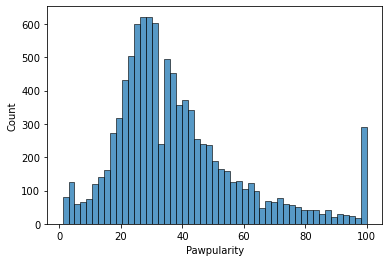

In [8]:
sns.histplot(df['Pawpularity']);

> Here we take at a look at the distribution of the target `Pawpularity` and see a spike at 100.

In [9]:
# Download images to notebook
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (128, 128), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

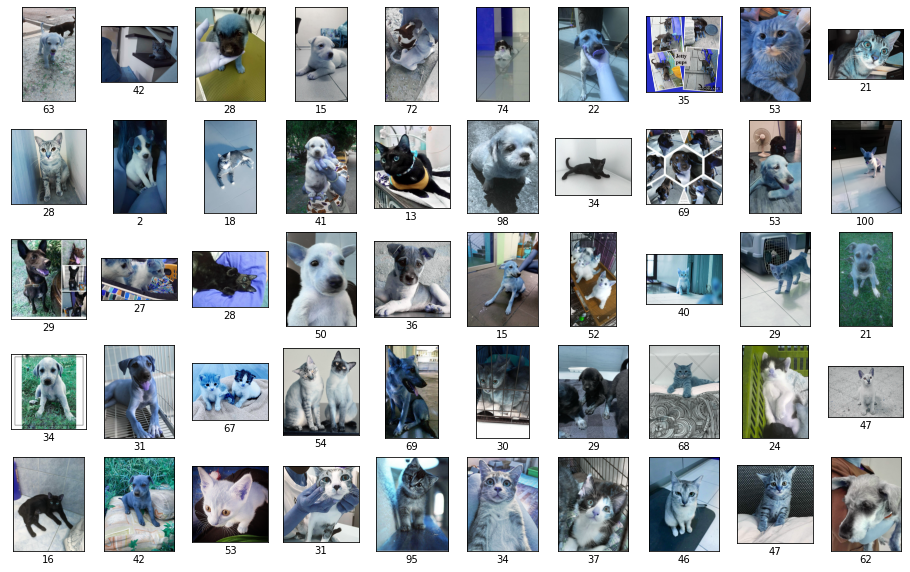

In [10]:
# Plot first 50 images
def image_read(path):
    return cv2.imread(path)

df['path'] = df.apply(lambda x : 'data/train/' + x['Id'] + ".jpg", axis=1)
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(df[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

> We see a variety of cat and dog photos and their `Pawpularity` score. Something we notice is that the photos lean blue but do not know why and cannot find more information on this.

In [11]:
# Transforming images list to numpy array for modeling and assigning it to X and defining target variable y
X = np.array(images)
y = df['Pawpularity']

# Checking shape of X
X.shape

(9912, 128, 128, 3)

In [12]:
# Do a train-test-split using a random state of 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

---

# <a id="Modeling">Modeling</a>

> We start by creating functions for model building and evaluation to streamline our process.

In [13]:
# Function for model building
def model_compfit(model, X_train, y_train, n_epochs):
    """Function to compile our models using our chosen optimizer, loss,
    and evaluation metrics. The function then fits the model on our train
    data and n number epochs, finally printing out a model summary."""
    
    # compile model with adam optimizer and mean squared error metric
    model.compile(optimizer='adam',
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])
    # fit model on train sets with n number epochs
    model.fit(X_train, y_train, epochs=n_epochs)
    
    #print model summary
    model.summary()

In [14]:
# Function for model evaluation
def model_eval(model, X_train, y_train, X_test, y_test, name):
    """Function to evaluate our model on the training and test 
    data, then printing out those metrics, and visualizing the
    predictions on the test data."""
    
    # calculate training data metrics
    train_eval = model.evaluate(X_train, y_train)
    
    # calculate test data metrics
    test_eval = model.evaluate(X_test, y_test)
    
    # print metrics
    print(f"""
    {name} Training Metrics:
    Loss: {round(train_eval[0] , 3)}
    RMSE: {round(train_eval[1] , 3)} 
    ------
    {name} Test Metrics:
    Loss: {round(test_eval[0] , 3)}
    RMSE: {round(test_eval[1] , 3)}
    """)
    
    # visualize predictions
    ypred = model.predict(X_test)
    x_ax = range(len(ypred))
    plt.figure(figsize=(20,10))
    plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
    plt.plot(x_ax, ypred, lw=1, color="red", label="predicted")
    plt.legend()
    plt.show()

### <a id="Baseline Dummy Regressor">Baseline Dummy Regressor<a>

> We start off with a Baseline Dummy Regressor to compare our models to and try to improve upon.

In [15]:
baseline = DummyRegressor(strategy="mean")
baseline.fit (X_train,y_train)
y_hat_test = baseline.predict(X_test)
baseline_rmse = mse(y_test, y_hat_test, squared=False)

In [16]:
baseline_rmse

21.074920522735773

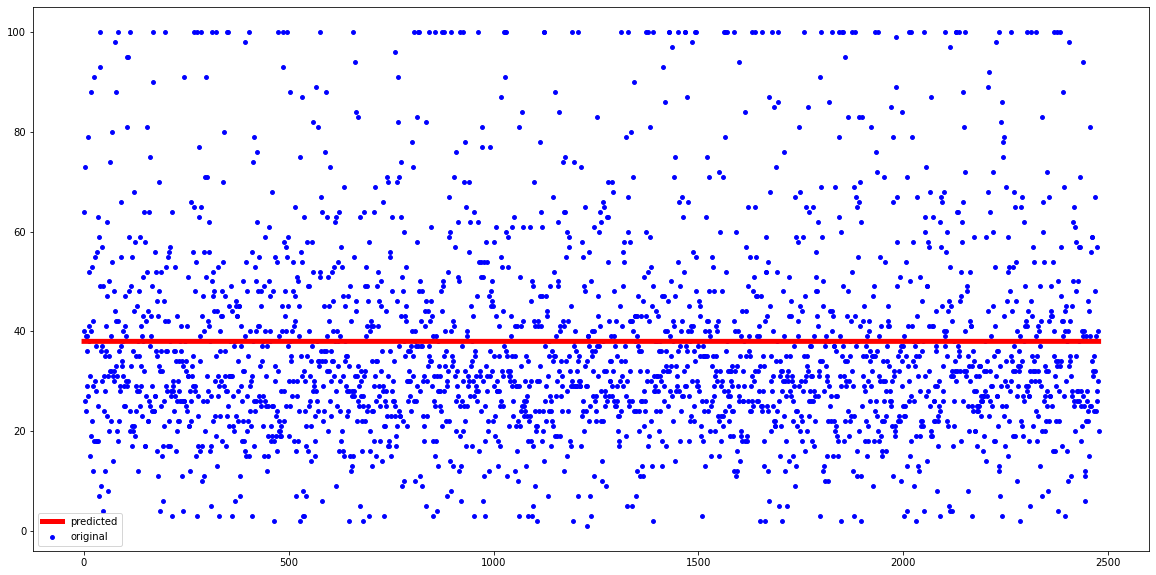

In [17]:
ypred = baseline.predict(X_test)
x_ax = range(len(ypred))
plt.figure(figsize=(20,10))
plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
plt.plot(x_ax, ypred, lw=5, color="red", label="predicted")
plt.legend()
plt.show()

### <a id="First Basic Model and Image Augmentation">First Basic Model and Image Augmentation</a>

> Our first basic model is an Artificial Neural Network with one layer.

In [18]:
basicann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(basicann, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 2s 7ms/step - loss: 498.5932 - root_mean_squared_error: 22.3292
Epoch 2/10
233/233 [==============================] - 1s 5ms/step - loss: 499.8664 - root_mean_squared_error: 22.3577
Epoch 3/10
233/233 [==============================] - 1s 5ms/step - loss: 479.0622 - root_mean_squared_error: 21.8875
Epoch 4/10
233/233 [==============================] - 1s 5ms/step - loss: 488.3990 - root_mean_squared_error: 22.0998
Epoch 5/10
233/233 [==============================] - 1s 4ms/step - loss: 474.0719 - root_mean_squared_error: 21.7732
Epoch 6/10
233/233 [==============================] - 1s 5ms/step - loss: 471.8141 - root_mean_squared_error: 21.7213
Epoch 7/10
233/233 [==============================] - 1s 5ms/step - loss: 471.9232 - root_mean_squared_error: 21.7238
Epoch 8/10
233/233 [==============================] - 2s 10ms/step - loss: 465.8413 - root_mean_squared_error: 21.5834
Epoch 9/10
233/233 [==============================] - 2

78/78 [==============================] - 0s 5ms/step - loss: 528.6611 - root_mean_squared_error: 22.9926

    Basic ANN Training Metrics:
    Loss: 453.561
    RMSE: 21.297 
    ------
    Basic ANN Test Metrics:
    Loss: 528.661
    RMSE: 22.993
    


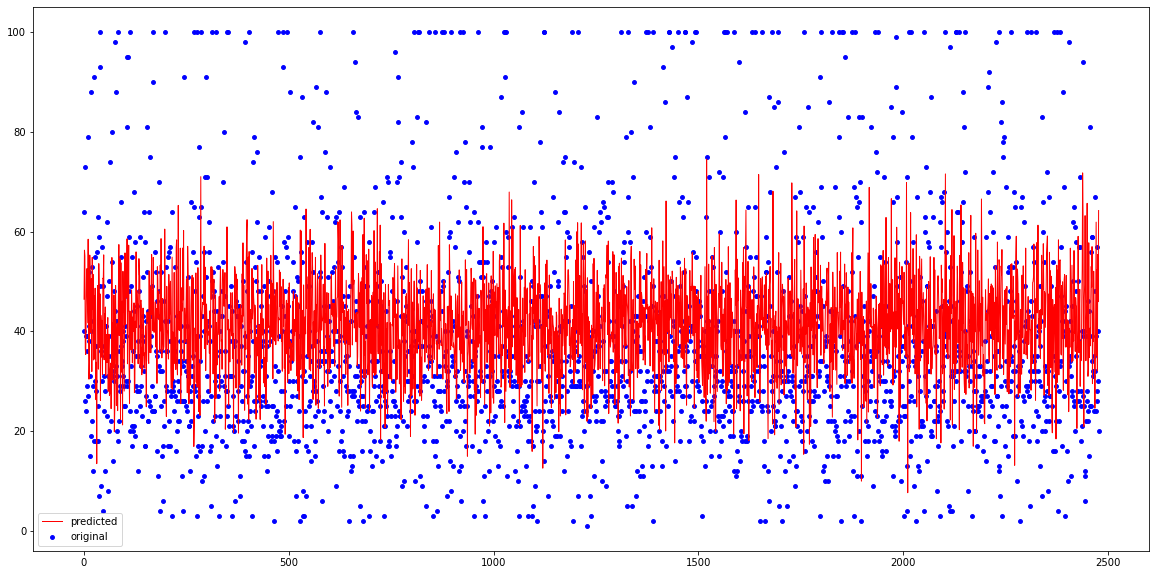

In [19]:
model_eval(basicann, X_train, y_train, X_test, y_test, 'Basic ANN')

> We do some image augmentation by blurring the photos to see how that affects our RMSE.

In [20]:
X_train_blur = []

for image in X_train:
    image = ndimage.gaussian_filter(image, sigma= 1)
    X_train_blur.append(image)
    
X_train_blur = np.array(X_train_blur)

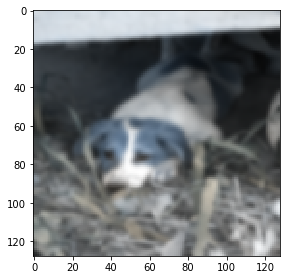

In [21]:
io.imshow(X_train_blur[0])

In [22]:
blurann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(blurann, X_train_blur, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 4ms/step - loss: 508.3556 - root_mean_squared_error: 22.5467
Epoch 2/10
233/233 [==============================] - 1s 4ms/step - loss: 488.4328 - root_mean_squared_error: 22.1005
Epoch 3/10
233/233 [==============================] - 1s 4ms/step - loss: 498.3028 - root_mean_squared_error: 22.3227
Epoch 4/10
233/233 [==============================] - 1s 4ms/step - loss: 491.4557 - root_mean_squared_error: 22.1688
Epoch 5/10
233/233 [==============================] - 1s 4ms/step - loss: 489.2918 - root_mean_squared_error: 22.1199
Epoch 6/10
233/233 [==============================] - 1s 4ms/step - loss: 478.0587 - root_mean_squared_error: 21.8646
Epoch 7/10
233/233 [==============================] - 1s 4ms/step - loss: 487.8592 - root_mean_squared_error: 22.0875
Epoch 8/10
233/233 [==============================] - 1s 4ms/step - loss: 482.4075 - root_mean_squared_error: 21.9638
Epoch 9/10
233/233 [==============================] - 1s

78/78 [==============================] - 1s 8ms/step - loss: 541.4640 - root_mean_squared_error: 23.2694

    Blurred ANN Training Metrics:
    Loss: 470.519
    RMSE: 21.691 
    ------
    Blurred ANN Test Metrics:
    Loss: 541.464
    RMSE: 23.269
    


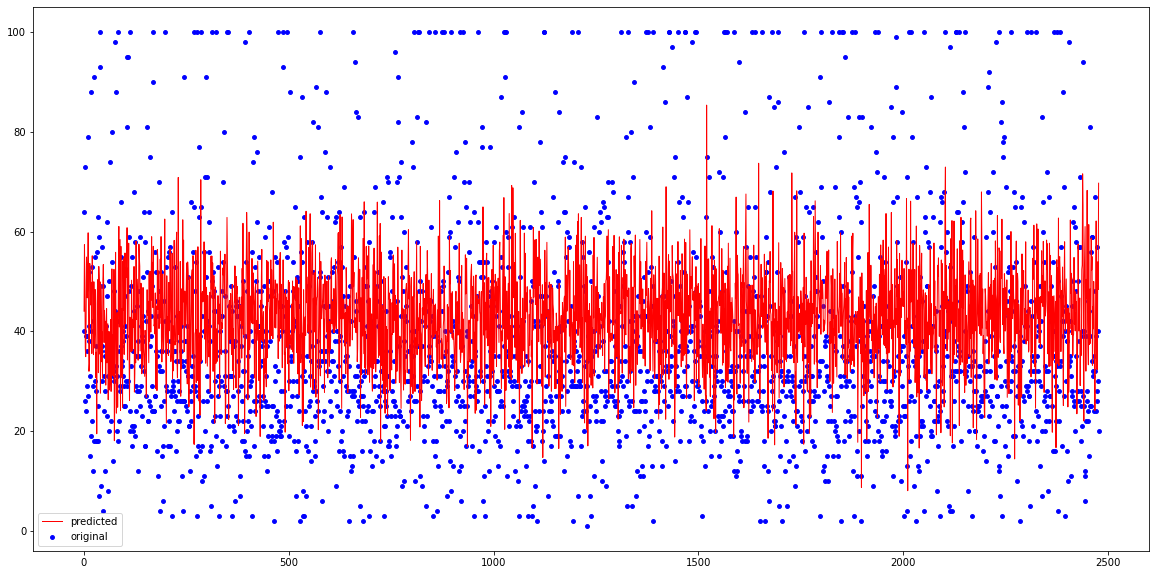

In [23]:
model_eval(blurann, X_train_blur, y_train, X_test, y_test, 'Blurred ANN')

> We then flip the images horizontally.

In [24]:
X_train_flip = []

for image in X_train:
    image = cv2.flip(image,1)
    X_train_flip.append(image)
    
X_train_flip = np.array(X_train_flip)

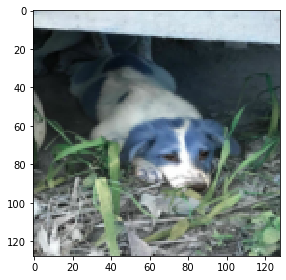

In [25]:
io.imshow(X_train_flip[0])

In [26]:
flipann = Sequential([
            Flatten(),
            Dense(1, activation='relu')
          ])

model_compfit(flipann, X_train_flip, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 5ms/step - loss: 515.4820 - root_mean_squared_error: 22.7042
Epoch 2/10
233/233 [==============================] - 1s 5ms/step - loss: 491.3006 - root_mean_squared_error: 22.1653
Epoch 3/10
233/233 [==============================] - 1s 5ms/step - loss: 484.7204 - root_mean_squared_error: 22.0164
Epoch 4/10
233/233 [==============================] - 1s 5ms/step - loss: 485.3916 - root_mean_squared_error: 22.0316
Epoch 5/10
233/233 [==============================] - 1s 5ms/step - loss: 487.7504 - root_mean_squared_error: 22.0851
Epoch 6/10
233/233 [==============================] - 1s 5ms/step - loss: 493.7435 - root_mean_squared_error: 22.2203
Epoch 7/10
233/233 [==============================] - 1s 5ms/step - loss: 462.7820 - root_mean_squared_error: 21.5124
Epoch 8/10
233/233 [==============================] - 1s 5ms/step - loss: 467.0221 - root_mean_squared_error: 21.6107
Epoch 9/10
233/233 [==============================] - 1s

78/78 [==============================] - 1s 7ms/step - loss: 502.3939 - root_mean_squared_error: 22.4141

    Flipped ANN Training Metrics:
    Loss: 429.96
    RMSE: 20.735 
    ------
    Flipped ANN Test Metrics:
    Loss: 502.394
    RMSE: 22.414
    


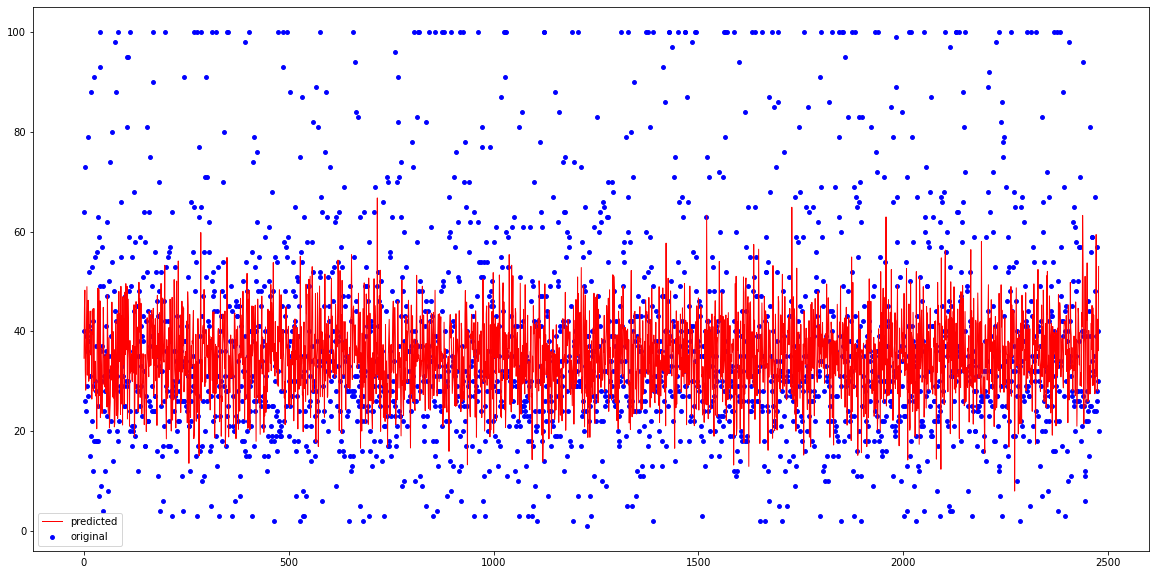

In [27]:
model_eval(flipann, X_train_flip, y_train, X_test, y_test, 'Flipped ANN')

> Both types of image augmentation performed worse than our baseline.

### <a id="Iterative Artificial Neural Network Building">Iterative Artificial Neural Networks</a>

> We move on to build more complex ANN models.

In [28]:
ann2 = Sequential([
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(1, activation='relu')
      ])

model_compfit(ann2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 87s 372ms/step - loss: 2517.0427 - root_mean_squared_error: 50.1701
Epoch 2/10
233/233 [==============================] - 87s 373ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 3/10
233/233 [==============================] - 81s 348ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 4/10
233/233 [==============================] - 75s 320ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 5/10
233/233 [==============================] - 72s 308ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 6/10
233/233 [==============================] - 72s 310ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 7/10
233/233 [==============================] - 72s 308ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 8/10
233/233 [==============================] - 72s 308ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 9/10
233/233 [====

78/78 [==============================] - 7s 96ms/step - loss: 1898.7963 - root_mean_squared_error: 43.5752

    Second ANN Training Metrics:
    Loss: 1861.676
    RMSE: 43.147 
    ------
    Second ANN Test Metrics:
    Loss: 1898.796
    RMSE: 43.575
    


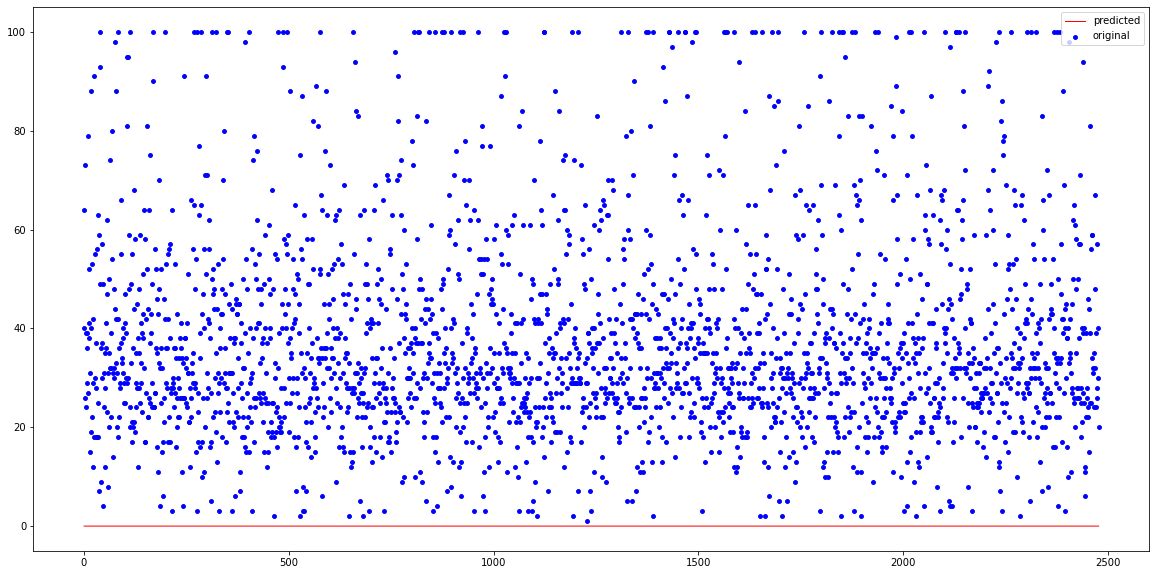

In [29]:
model_eval(ann2, X_train, y_train, X_test, y_test, 'Second ANN')

In [30]:
ann3 = Sequential([
        Flatten(),
        Dense(3000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(10, activation='relu')
      ])

model_compfit(ann3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 207s 890ms/step - loss: 1239.5125 - root_mean_squared_error: 35.2067
Epoch 2/10
233/233 [==============================] - 193s 830ms/step - loss: 1027.4346 - root_mean_squared_error: 32.0536
Epoch 3/10
233/233 [==============================] - 199s 853ms/step - loss: 1026.6284 - root_mean_squared_error: 32.0410
Epoch 4/10
233/233 [==============================] - 177s 759ms/step - loss: 1021.8079 - root_mean_squared_error: 31.9657
Epoch 5/10
233/233 [==============================] - 166s 713ms/step - loss: 1017.9619 - root_mean_squared_error: 31.9055
Epoch 6/10
233/233 [==============================] - 170s 729ms/step - loss: 1017.0810 - root_mean_squared_error: 31.8917
Epoch 7/10
233/233 [==============================] - 166s 714ms/step - loss: 1013.6356 - root_mean_squared_error: 31.8376
Epoch 8/10
233/233 [==============================] - 166s 714ms/step - loss: 1012.2665 - root_mean_squared_error: 31.8161
Epoch 9/10
233/2

78/78 [==============================] - 11s 138ms/step - loss: 1049.9214 - root_mean_squared_error: 32.4025

    Third ANN Training Metrics:
    Loss: 995.332
    RMSE: 31.549 
    ------
    Third ANN Test Metrics:
    Loss: 1049.921
    RMSE: 32.402
    


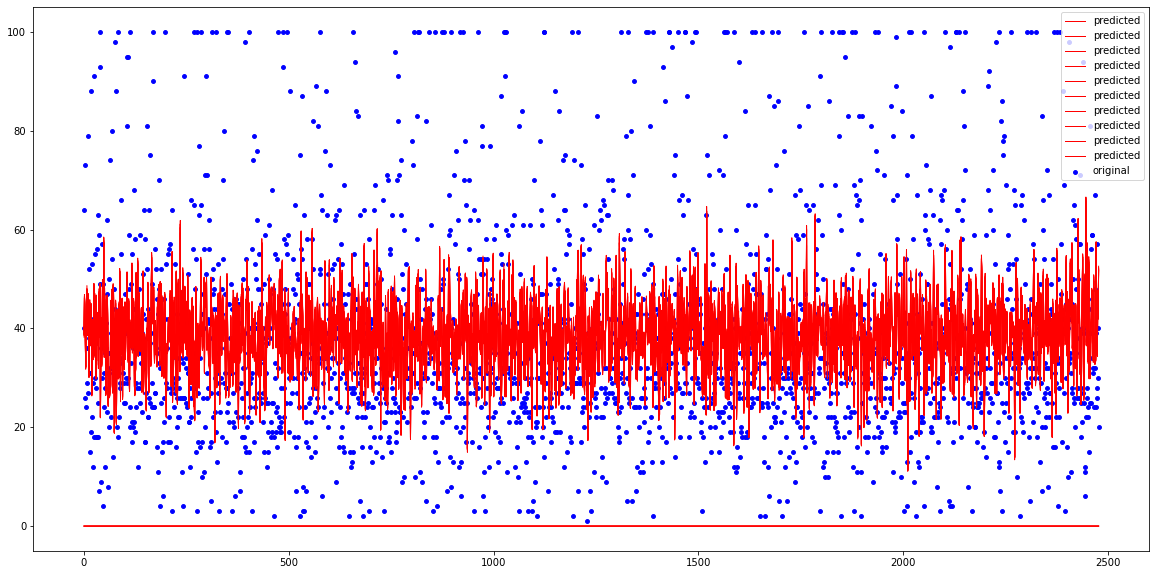

In [31]:
model_eval(ann3, X_train, y_train, X_test, y_test, 'Third ANN')

In [32]:
ann4 = Sequential([
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann4, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 9s 39ms/step - loss: 1889.0084 - root_mean_squared_error: 43.4627
Epoch 2/10
233/233 [==============================] - 8s 33ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 3/10
233/233 [==============================] - 7s 31ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 4/10
233/233 [==============================] - 7s 32ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 5/10
233/233 [==============================] - 7s 32ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 6/10
233/233 [==============================] - 8s 33ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 7/10
233/233 [==============================] - 8s 32ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 8/10
233/233 [==============================] - 7s 31ms/step - loss: 1861.6760 - root_mean_squared_error: 43.1471
Epoch 9/10
233/233 [====================

78/78 [==============================] - 2s 22ms/step - loss: 1898.7963 - root_mean_squared_error: 43.5752

    Fourth ANN Training Metrics:
    Loss: 1861.676
    RMSE: 43.147 
    ------
    Fourth ANN Test Metrics:
    Loss: 1898.796
    RMSE: 43.575
    


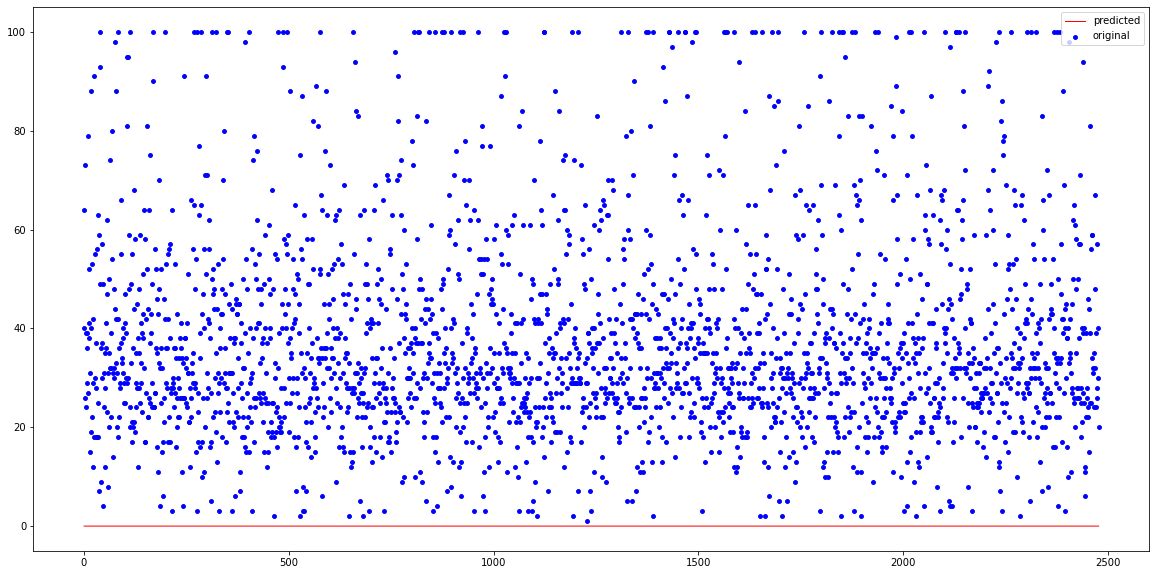

In [33]:
model_eval(ann4, X_train, y_train, X_test, y_test, 'Fourth ANN')

In [35]:
ann5 = tf.keras.Sequential([
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann5, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 11s 48ms/step - loss: 516.1583 - root_mean_squared_error: 22.7191
Epoch 2/10
233/233 [==============================] - 13s 58ms/step - loss: 482.3322 - root_mean_squared_error: 21.9621
Epoch 3/10
233/233 [==============================] - 23s 101ms/step - loss: 469.8159 - root_mean_squared_error: 21.6752
Epoch 4/10
233/233 [==============================] - 17s 74ms/step - loss: 473.5893 - root_mean_squared_error: 21.7621
Epoch 5/10
233/233 [==============================] - 14s 59ms/step - loss: 467.6059 - root_mean_squared_error: 21.6242
Epoch 6/10
233/233 [==============================] - 18s 76ms/step - loss: 452.8302 - root_mean_squared_error: 21.2798
Epoch 7/10
233/233 [==============================] - 13s 56ms/step - loss: 456.5316 - root_mean_squared_error: 21.3666
Epoch 8/10
233/233 [==============================] - 12s 50ms/step - loss: 447.3635 - root_mean_squared_error: 21.1510
Epoch 9/10
233/233 [===================

78/78 [==============================] - 1s 19ms/step - loss: 487.1628 - root_mean_squared_error: 22.0718

    Fifth ANN Training Metrics:
    Loss: 429.52
    RMSE: 20.725 
    ------
    Fifth ANN Test Metrics:
    Loss: 487.163
    RMSE: 22.072
    


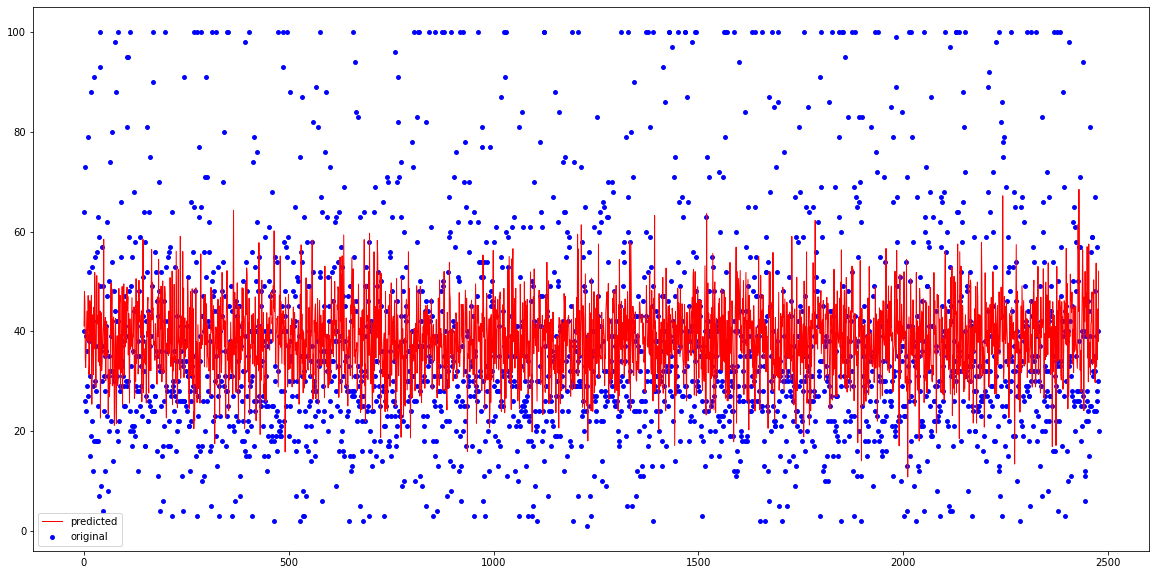

In [36]:
model_eval(ann5, X_train, y_train, X_test, y_test, 'Fifth ANN')

> We made five total ANN models, and they all performed worse than the baseline.

### <a id="Iterative Convolutional Neural Network Building">Iterative Convolutional Neural Networks</a>

> We move on to making Convolutional Neural Network models, hoping to do better than our baseline.

In [37]:
CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 202s 869ms/step - loss: 487.6511 - root_mean_squared_error: 22.0828
Epoch 2/10
233/233 [==============================] - 159s 683ms/step - loss: 432.6213 - root_mean_squared_error: 20.7995
Epoch 3/10
233/233 [==============================] - 159s 680ms/step - loss: 428.8285 - root_mean_squared_error: 20.7082
Epoch 4/10
233/233 [==============================] - 154s 659ms/step - loss: 427.0878 - root_mean_squared_error: 20.6661
Epoch 5/10
233/233 [==============================] - 160s 686ms/step - loss: 424.5081 - root_mean_squared_error: 20.6036
Epoch 6/10
233/233 [==============================] - 211s 906ms/step - loss: 423.5745 - root_mean_squared_error: 20.5809
Epoch 7/10
233/233 [==============================] - 153s 656ms/step - loss: 420.7753 - root_mean_squared_error: 20.5128
Epoch 8/10
233/233 [==============================] - 151s 646ms/step - loss: 422.0416 - root_mean_squared_error: 20.5437
Epoch 9/10
233/233 [====

78/78 [==============================] - 11s 142ms/step - loss: 459.9646 - root_mean_squared_error: 21.4468

    First CNN Training Metrics:
    Loss: 425.604
    RMSE: 20.63 
    ------
    First CNN Test Metrics:
    Loss: 459.965
    RMSE: 21.447
    


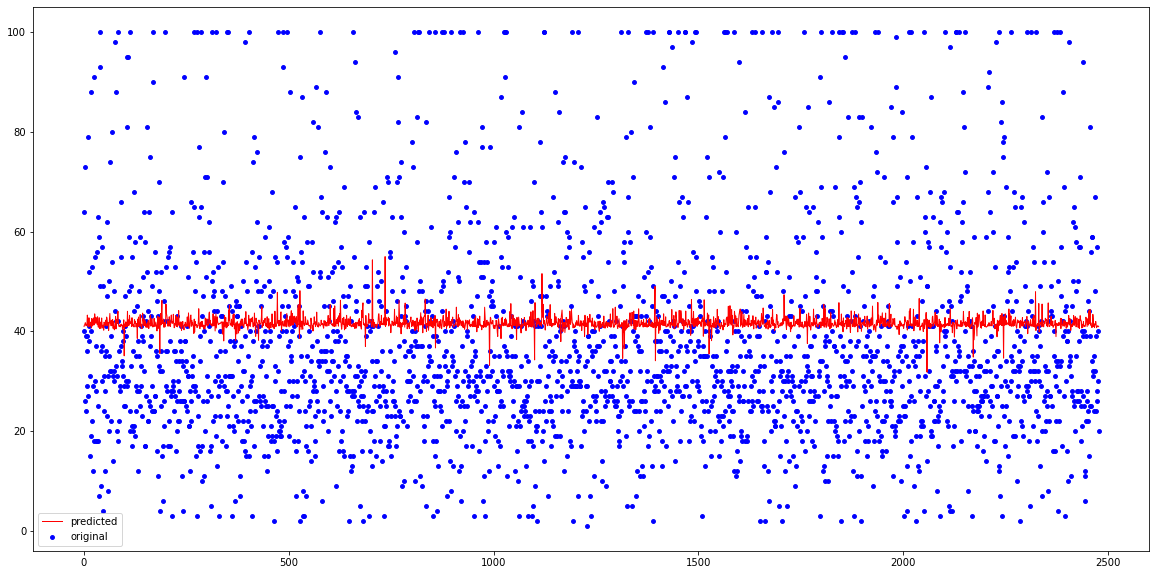

In [44]:
model_eval(CNN, X_train, y_train, X_test, y_test, 'First CNN')

In [45]:
CNN2 = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 87s 374ms/step - loss: 479.8156 - root_mean_squared_error: 21.9047
Epoch 2/10
233/233 [==============================] - 83s 355ms/step - loss: 434.9066 - root_mean_squared_error: 20.8544
Epoch 3/10
233/233 [==============================] - 79s 337ms/step - loss: 424.2919 - root_mean_squared_error: 20.5983
Epoch 4/10
233/233 [==============================] - 80s 343ms/step - loss: 403.6696 - root_mean_squared_error: 20.0915
Epoch 5/10
233/233 [==============================] - 80s 344ms/step - loss: 379.1942 - root_mean_squared_error: 19.4729
Epoch 6/10
233/233 [==============================] - 73s 314ms/step - loss: 329.8124 - root_mean_squared_error: 18.1607
Epoch 7/10
233/233 [==============================] - 73s 313ms/step - loss: 266.5419 - root_mean_squared_error: 16.3261
Epoch 8/10
233/233 [==============================] - 75s 320ms/step - loss: 214.0641 - root_mean_squared_error: 14.6309
Epoch 9/10
233/233 [============

78/78 [==============================] - 9s 118ms/step - loss: 602.0927 - root_mean_squared_error: 24.5376

    Second CNN Training Metrics:
    Loss: 74.156
    RMSE: 8.611 
    ------
    Second CNN Test Metrics:
    Loss: 602.093
    RMSE: 24.538
    


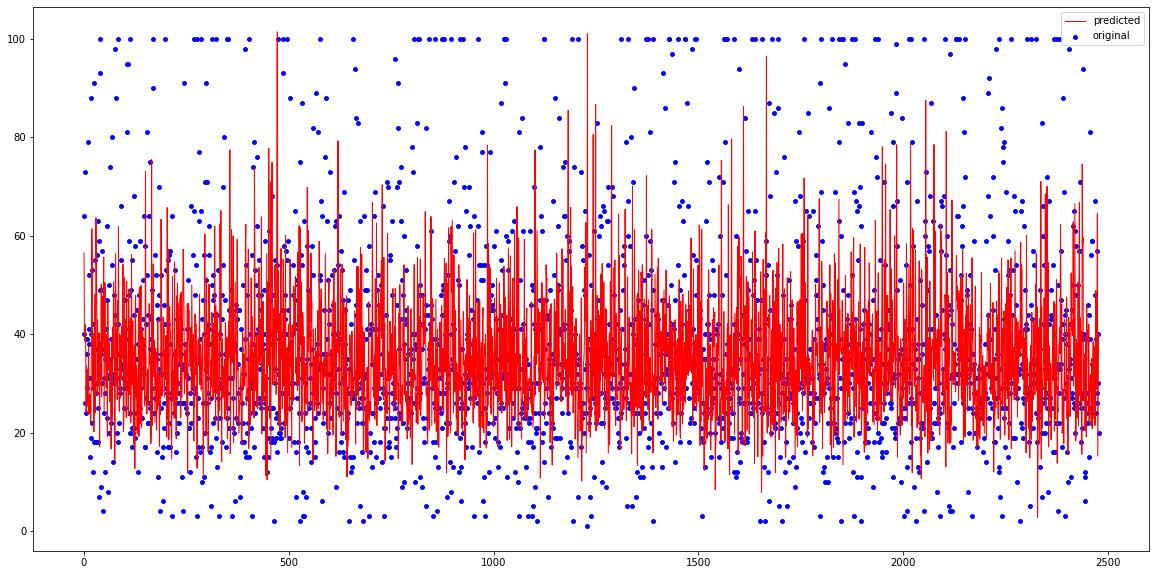

In [51]:
model_eval(CNN2, X_train, y_train, X_test, y_test, 'Second CNN')

In [52]:
CNN3 = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation=None),
])

model_compfit(CNN3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 194s 835ms/step - loss: 458.8270 - root_mean_squared_error: 21.4202
Epoch 2/10
233/233 [==============================] - 167s 718ms/step - loss: 427.9318 - root_mean_squared_error: 20.6865
Epoch 3/10
233/233 [==============================] - 155s 666ms/step - loss: 423.3220 - root_mean_squared_error: 20.5748
Epoch 4/10
233/233 [==============================] - 156s 667ms/step - loss: 424.7882 - root_mean_squared_error: 20.6104
Epoch 5/10
233/233 [==============================] - 156s 669ms/step - loss: 421.2358 - root_mean_squared_error: 20.5240
Epoch 6/10
233/233 [==============================] - 158s 680ms/step - loss: 420.5063 - root_mean_squared_error: 20.5063
Epoch 7/10
233/233 [==============================] - 157s 675ms/step - loss: 424.1791 - root_mean_squared_error: 20.5956
Epoch 8/10
233/233 [==============================] - 156s 668ms/step - loss: 417.7438 - root_mean_squared_error: 20.4388
Epoch 9/10
233/233 [====

78/78 [==============================] - 14s 186ms/step - loss: 500.4067 - root_mean_squared_error: 22.3698

    Third CNN Training Metrics:
    Loss: 451.807
    RMSE: 21.256 
    ------
    Third CNN Test Metrics:
    Loss: 500.407
    RMSE: 22.37
    


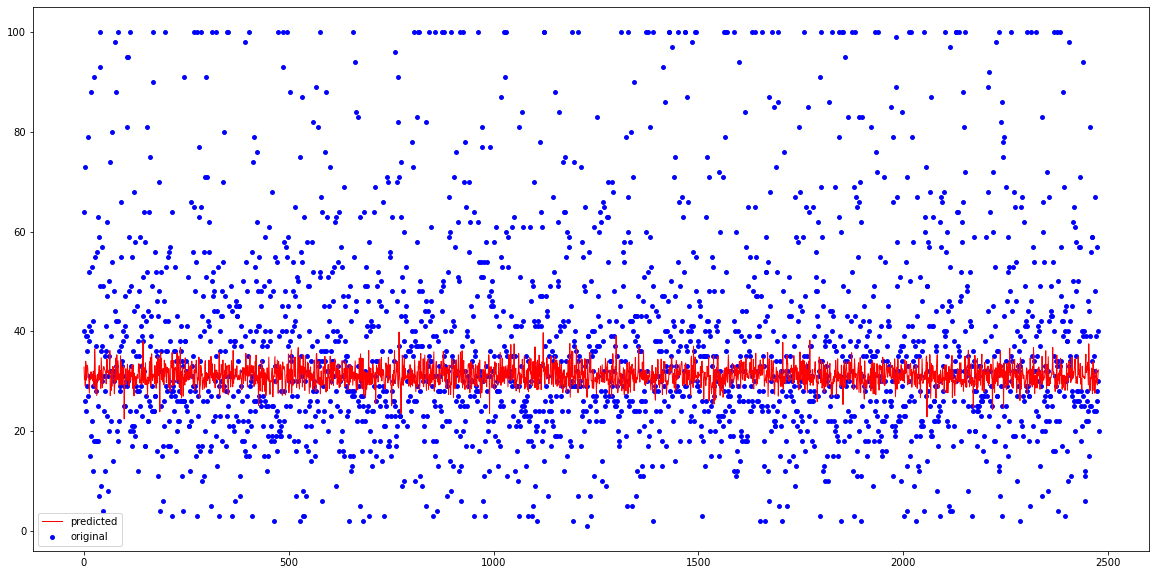

In [53]:
model_eval(CNN3, X_train, y_train, X_test, y_test, 'Third CNN')

> After running these 3 CNN models, we were not able to improve our RMSE from the baseline.

---

# <a id="Conclusion">Conclusion</a>

> We attempted Data Augmentation but found that Blurring and Flipping the images did not improve our RMSE.
>
> One big concern for us was that how `Pawpularity` was determined was unclear. There wasn't much information on the Kaggle competition description that explained how the score was created and how to interpret it. We know the scale is from 1-100, but do all the images with a score of 100 have the same amount of traffic? We think understanding how `Pawpularity` is scored would help us prepare the data for better model results.
>
> As we only had three days to complete this project, this is the best we could do.

---

# <a id="Next Steps">Next Steps</a>

> First, we would look into what goes into determining `Pawpularity`. Another thing we would like to look into would be features other than photos that affect pet profile traffic such as age of the animal and time they've been up for adoption. Lastly, our knowledge of neural networks is limited, and so, given more time, we would have liked to explore further.

## <a id="Sources">Sources</a>
- [Kaggle Competition Dataset](https://www.kaggle.com/c/petfinder-pawpularity-score)
- [Photo Metadata](https://github.com/stevenaddison/Project-4/blob/main/data/metadata.md)
- [Speed of Dog Adoption: Impact of Online Photo Traits](https://www.tandfonline.com/doi/full/10.1080/10888705.2014.982796)